In [1]:
# import library yang dibutuhkan
import os
import re
import math
from spacy.lang.id import Indonesian
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from spacy.lang.id.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# path berisi lokasi file-file berita
path = "D:/RAIHAN STIS/Perkuliahan/SEMESTER 5/Praktikum INFORMATION RETRIEVAL/Pertemuan (2)/berita"

nlp = Indonesian()

# cleaning file berita
berita = []
for file_name in sorted(os.listdir(path)):
    file_path = os.path.join(path, file_name)

    with open(file_path, 'r') as f:
        clean_txt = re.sub("http\S+", ' ', f.read())
        clean_txt = re.sub("[^\w\s0-9]|['\d+']|[\'\",.!?:;<>()\[\]{}@#$%^&*=_+/\\\\|~-]]|(\'\')", ' ', clean_txt)
        clean_txt = re.sub("[\n\n]", ' ', clean_txt)
        clean_txt = re.sub(r'\s+', ' ', clean_txt).strip()
        berita.append(clean_txt)

# membuat dictionary yang berisi nomor dokumen dan isinya
doc_dict = {}
for i in range(1, len(berita) + 1):
    words = berita[i - 1].split()
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    stemming = StemmerFactory().create_stemmer()
    stemmed_words = [stemming.stem(word) for word in filtered_words]

    doc_dict[i] = " ".join(stemmed_words)

# membuat inverted index
token_arrays = []
for doc in berita:
    text_low = doc.lower()
    nlp_doc = nlp(text_low)
    token_doc = [token.text for token in nlp_doc]
    token_stpwords_tugas = [w for w in token_doc if w not in STOP_WORDS]
    token_arrays.append(token_stpwords_tugas)

inverted_index = {}
for i in range(len(token_arrays)):
    for item in token_arrays[i]:
        item = stemming.stem(item)
        if item not in inverted_index:
            inverted_index[item] = []
        if (item in inverted_index) and ((i+1) not in inverted_index[item]):
            inverted_index[item].append(i+1)

vocab = list(inverted_index.keys())

def termFrequencyInDoc(vocab, doc_dict):
    tf_docs = {}
    for doc_id in doc_dict.keys():
        tf_docs[doc_id] = {}
    for word in vocab:
        for doc_id,doc in doc_dict.items():
            tf_docs[doc_id][word] = doc.count(word)
    return tf_docs

def tokenisasi(text):
    tokens = text.split(" ")
    return tokens

def wordDocFre(vocab, doc_dict):
  df = {}
  for word in vocab:
    frq = 0
    for doc in doc_dict.values():
      if word in tokenisasi(doc):
        frq = frq + 1
    df[word] = frq
  return df

import numpy as np
def inverseDocFre(vocab,doc_fre,length):
  idf= {}
  for word in vocab:
    idf[word] = idf[word] = 1 + np.log((length + 1) / (doc_fre[word]+1))
  return idf

# vektor space model
def tfidf(vocab,tf,idf_scr,doc_dict):
  tf_idf_scr = {}
  for doc_id in doc_dict.keys():
    tf_idf_scr[doc_id] = {}
  for word in vocab:
    for doc_id,doc in doc_dict.items():
      tf_idf_scr[doc_id][word] = tf[doc_id][word] * idf_scr[word]
  return tf_idf_scr

tf_idf = tfidf(vocab, termFrequencyInDoc(vocab, doc_dict), inverseDocFre(vocab, wordDocFre(vocab, doc_dict), len(doc_dict)), doc_dict)

# Term - Document Matrix
TD = np.zeros((len(vocab), len(doc_dict)))
for word in vocab:
  for doc_id,doc in tf_idf.items():
    ind1 = vocab.index(word)
    ind2 = list(tf_idf.keys()).index(doc_id)
    TD[ind1][ind2] = tf_idf[doc_id][word]

query = "vaksin corona jakarta"
def termFrequency(vocab, query):
    tf_query = {}
    for word in vocab:
        tf_query[word] = query.count(word)
    return tf_query

tf_query = termFrequency(vocab, query)

idf = inverseDocFre(vocab, wordDocFre(vocab, doc_dict), len(doc_dict))

# Term - Query Matrix
TQ = np.zeros((len(vocab), 1)) #hanya 1 query
for word in vocab:
    ind1 = vocab.index(word)
    TQ[ind1][0] = tf_query[word]*idf[word]


def cosine_sim(vec1, vec2):
    vec1 = list(vec1)
    vec2 = list(vec2)
    dot_prod = 0
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
    mag_1 = math.sqrt(sum([x**2 for x in vec1]))
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))

    return dot_prod / (mag_1 * mag_2)

from collections import OrderedDict
def exact_top_k(doc_dict, TD, q, k):
    relevance_scores = {}
    i = 0
    for doc_id in doc_dict.keys():
        relevance_scores[doc_id] = cosine_sim(q, TD[:, i])
        i = i + 1
    
    sorted_value = OrderedDict(sorted(relevance_scores.items(), key=lambda x: x[1], reverse = True))
    top_k = {j: sorted_value[j] for j in list(sorted_value)[:k]}
    return top_k

Matriks DT: 
[[ 1.69314718  2.09861229  2.          2.09861229  2.09861229  2.09861229
   2.09861229  2.09861229  1.40546511  1.          2.09861229  1.69314718
   4.19722458  2.09861229  2.09861229  2.09861229  2.09861229  6.29583687
   6.29583687  2.09861229  2.09861229  1.69314718  2.09861229  4.19722458
   7.02732554  2.09861229  2.09861229  2.09861229  2.09861229  2.09861229
   2.09861229  2.09861229  2.09861229  2.09861229 29.38057204  2.09861229
   1.69314718  1.69314718  2.09861229  2.09861229  2.09861229  1.69314718
   2.09861229  1.69314718  2.09861229  2.09861229  2.09861229  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   2.09861229  0.          0.          0.          0.          0.
   0.  

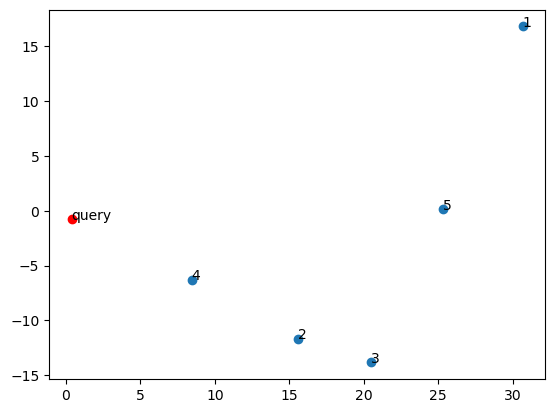

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

DT = TD.transpose()
print("Matriks DT: ")
print(DT)
model = TruncatedSVD(n_components=2, random_state=7).fit(DT)
DT_reduced = model.transform(DT)
QT_reduced = model.transform(TQ.transpose())

print("\nMatriks QT yang sudah direduksi:")
print(QT_reduced)
print("\nMatriks DT yang sudah direduksi:")
print(DT_reduced)

plt.scatter(DT_reduced[:, 0], DT_reduced[:, 1])
plt.scatter(QT_reduced[:, 0], QT_reduced[:, 1], color=["red"])

labels=list(doc_dict.keys())
for i, txt in enumerate(labels):
    plt.annotate(txt, (DT_reduced[i, 0], DT_reduced[i, 1]))

plt.annotate("query", (QT_reduced[0, 0], QT_reduced[0, 1]))
plt.show()

In [3]:
top_5 = exact_top_k(doc_dict, TD, TQ[:, 0], 5)
print(top_5)

{2: 0.305441706917711, 3: 0.30457740843687225, 4: 0.07688776837468171, 5: 0.051488176982188355, 1: 0.010832772328566935}


In [12]:
# rel_vecs_id = ["2","3"]
# nrel_vecs_id = ["1","4","5"]
# doc_ids = ["1","2","3","4","5"]

rel_vecs_id = [2,3]
nrel_vecs_id = [3,4,5]
doc_ids = list(doc_dict.keys())

rel_vecs = []
for doc in rel_vecs_id:
    rel_vecs.append(DT[doc_ids.index(doc),:])

nrel_vecs = []
for doc in nrel_vecs_id:
    nrel_vecs.append(DT[doc_ids.index(doc),:])

[1, 2, 3, 4, 5]


In [5]:
query_vecs = TQ.transpose()
alpha = 1
beta = 0.75
gamma = 0.15

# Update query vectors with Rocchio algorithm
query_vecs = alpha * query_vecs + beta * np.mean(rel_vecs, axis=0) - gamma * np.mean(nrel_vecs, axis=0)
query_vecs[query_vecs<0] = 0 #negative value => 0

In [6]:
top_5 = exact_top_k(doc_dict, TD, query_vecs[0, :].transpose(), 5)
print(top_5)

{2: 0.9098976924594369, 3: 0.8947332898101339, 5: 0.5338741830247885, 1: 0.3727910067294201, 4: 0.304891983481142}


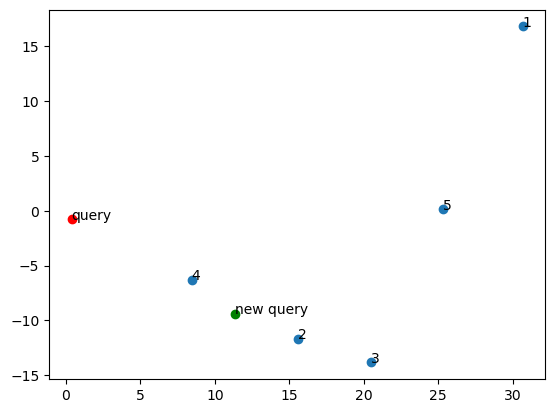

In [7]:
QT1_reduced = model.transform(query_vecs)
plt.scatter(DT_reduced[:, 0], DT_reduced[:, 1])
plt.scatter(QT_reduced[:, 0], QT_reduced[:, 1], color=["red"])
plt.scatter(QT1_reduced[:, 0], QT1_reduced[:, 1], color=["green"])

doc_ids=list(doc_dict.keys())
for i, txt in enumerate(doc_ids):
    plt.annotate(txt, (DT_reduced[i, 0], DT_reduced[i, 1]))
    
plt.annotate("query", (QT_reduced[0, 0], QT_reduced[0, 1]))
plt.annotate("new query", (QT1_reduced[:, 0], QT1_reduced[:, 1]))
plt.show()

In [8]:
def tokenisasi(text):
    tokens = text.split(" ")
    return tokens

def stemming(text):
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    # create stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # stemming process
    output = stemmer.stem(text)
    return output

In [9]:
def elim_query(query, idf_dict, idf_score):
    for term in tokenisasi(query):
        if idf_dict[stemming(term)]<idf_score:
            query = query.replace(term+" ", "")
            query = query.replace(term, "")
    return query

query1 = "virus corona jakarta"
query1 = elim_query(query1, idf, 1.5)
print(query1)

virus corona 


In [10]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
from itertools import chain
from nltk.corpus import wordnet

query = query1

expand_list = []
for term in query.split(" "):
    synonyms = wordnet.synsets(term)
    lemmas = set(chain.from_iterable([word.lemma_names() for word in
    synonyms]))
    print(lemmas)
    expand_list = expand_list + list(lemmas)
    
print(expand_list)

query_expand = query + " " + (" ".join(expand_list)).replace("_", " ")
print(query_expand)

{'computer_virus', 'virus'}
{'corposant', "Saint_Elmo's_fire", 'electric_glow', 'corona', 'corona_discharge', "St._Elmo's_fire", "Saint_Ulmo's_light", 'aureole', "Saint_Elmo's_light", "Saint_Ulmo's_fire"}
set()
['computer_virus', 'virus', 'corposant', "Saint_Elmo's_fire", 'electric_glow', 'corona', 'corona_discharge', "St._Elmo's_fire", "Saint_Ulmo's_light", 'aureole', "Saint_Elmo's_light", "Saint_Ulmo's_fire"]
virus corona  computer virus virus corposant Saint Elmo's fire electric glow corona corona discharge St. Elmo's fire Saint Ulmo's light aureole Saint Elmo's light Saint Ulmo's fire
